<a href="https://colab.research.google.com/github/Chirag314/EDA/blob/main/spaceship_titanic1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [147]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', False)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)


from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
pd.set_option('max_rows',None)

In [148]:
#Helper functions

#Create function for missing data analysis
def draw_missing_data_table(df):
  total=df.isnull().sum().sort_values(ascending=False)
  percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_data=pd.concat([total,percent],axis=1,keys=['Total','Percent'])
  return missing_data

In [149]:
#Plot learning curve
def plot_learning_curve(estimator, title, x,y,ylim=None, cv=None,n_jobs=1,train_sizes=np.linspace(.1,1,5)):
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator,x,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    plt.grid()
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std,alpha=0.1,color='g')
    plt.plot(train_sizes,train_scores_mean,'o-',color='r',label="Training score")
    plt.plot(train_sizes,test_scores_mean,'o-',color='g',label='Validation score')
    plt.legend(loc="best")
    return plt

In [150]:
#plot validation curve
def plot_validation_curve(estimator, title,x,y,param_name,param_range,ylim=None,cv=None,n_jobs=1,train_sizes=np.linspace(.1,1,5)):
  train_scores,test_scores=validation_curve(estimator,x,y,param_name,param_range,cv)
  train_mean=np.mean(train_scores,axis=1)
  train_std=np.std(train_scores,axis=1)
  test_mean=np.mean(test_scores,axis=1)
  test_std=np.std(test_scores,axis=1)
  plt.plot(param_range,train_mean,color='r',marker='o',markersize=5,label='Training Score')
  plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15,color='r')
  plt.plot(param_range,test_mean,color='g',linstyle='--',marker='s',markersize=5,label='Validation score')
  plt.fill_between(param_range, test_mean+test_std, test_mean-test_std,alpha=0.15,color='g')
  plt.grid()
  plt.xscale('log')
  plt.legend(loc='best')
  plt.xlabel('Parameter')
  plt.ylabel('Score')
  plt.ylim(ylim)

In [151]:
#get path from training and test data
curr_path = os.getcwd()
dataset_src=os.path.join(curr_path,'spaceship titanic')
train_path=os.path.join(dataset_src,'train.csv')
test_path=os.path.join(dataset_src,'test.csv')

In [152]:
#import data
train_df=pd.read_csv(train_path)
test_df=pd.read_csv(test_path)
df=pd.read_csv('train.csv')
df_raw=df.copy()
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Exploratory Data Analysis
Not all features provide necessary information for the model. It is essentil to find out important features for analysis.


In [153]:
# Check for missing values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [154]:
# Define the function that creates missing value heatmap
def plot_missing_data(dataset, title):
  fig,ax=plt.subplots(figsize=(5,5))
  plt.title(title)
  sns.heatmap(dataset,cbar=False)

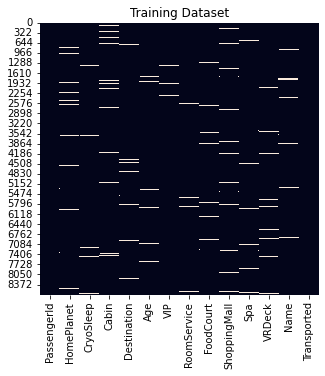

In [155]:
plot_missing_data(df.isnull(),"Training Dataset")

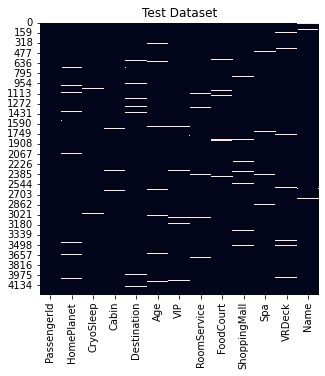

In [156]:
plot_missing_data(test_df.isnull(),"Test Dataset")

In [157]:
# Check number of  missing values in each columns
draw_missing_data_table(train_df)

,Total,Percent
CryoSleep,217,0.024963
ShoppingMall,208,0.023927
VIP,203,0.023352
HomePlanet,201,0.023122
Name,200,0.023007
Cabin,199,0.022892
VRDeck,188,0.021627
FoodCourt,183,0.021051
Spa,183,0.021051
Destination,182,0.020936


In [158]:
# THere may be rows where most of the values missing except PassengerId and Transported. We definitely dont want those rows as they may take analysis in
# Different direction
# Drop rows which contain all NaN values except two
print('Before dropping: {} '.format(len(train_df)))
train_df = train_df.dropna(axis=0, how='all',thresh=3)

print('After dropping: {}'.format(len(train_df)))


Before dropping: 8693 
After dropping: 8693


In [159]:
#FInd rows with specific NAN values. There are 14 columns and last two has non missing values. Lets check if there are any rows where all are
#missing except last two.
print('Before dropping: {} '.format(len(train_df)))
train_df[train_df.isna().sum(axis=1)>10]
print('After dropping: {}'.format(len(train_df)))
# It seems there are no rows with more than 10 NaN's let go down decreasing the values and check

Before dropping: 8693 
After dropping: 8693


In [160]:
#Ther are max 3 missing values in row. Lets check how many rows like this

train_df[train_df.isna().sum(axis=1)==3].shape


(17, 14)

In [161]:
# So there are 17 rows with 3 NaN's in each rows. Since our dataframe contains more than 8000 rows, deleting 17 wont effect much in analysis.
print('Before dropping: {} '.format(len(train_df)))
train_df.drop(train_df[train_df.isna().sum(axis=1)==3].index,inplace=True)
print('After dropping: {}'.format(len(train_df)))

Before dropping: 8693 
After dropping: 8676


In [162]:
# Now check NaNs again
draw_missing_data_table(train_df)

,Total,Percent
CryoSleep,211,0.024320
ShoppingMall,204,0.023513
VIP,199,0.022937
HomePlanet,196,0.022591
Name,195,0.022476
Cabin,194,0.022361
VRDeck,185,0.021323
RoomService,181,0.020862
FoodCourt,180,0.020747
Spa,178,0.020516


In [163]:
#Ther are max 3 missing values in row. Lets check how many rows have two missing values
train_df[train_df.isna().sum(axis=1)==2].drop

<bound method DataFrame.drop of      PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  RoomService  FoodCourt  ShoppingMall     Spa   VRDeck                Name  Transported
59       0064_02        NaN      True     E/3/S    TRAPPIST-1e  33.0  False          0.0        0.0           NaN     0.0      0.0         Colatz Keen         True
111      0115_01       Mars       NaN    F/24/P    TRAPPIST-1e  26.0  False          0.0        0.0           0.0     0.0      NaN           Rohs Pead         True
181      0202_02     Europa     False     A/2/P    55 Cancri e   NaN  False          0.0     2433.0           NaN   878.0    443.0       Vegas Embleng         True
186      0210_01        NaN      True     D/6/P    55 Cancri e  24.0  False          0.0        0.0           NaN     0.0      0.0      Arraid Inicont         True
251      0278_01      Earth     False       NaN    TRAPPIST-1e  35.0  False          0.0        0.0           0.0   888.0      NaN       Judya Beach

In [164]:
##Whoa.. there are 203 rows with 2 missing values.. lets drop them also
print('Before dropping: {} '.format(len(train_df)))
train_df.drop(train_df[train_df.isna().sum(axis=1)==2].index,inplace=True)
print('After dropping: {}'.format(len(train_df)))

Before dropping: 8676 
After dropping: 8473


In [165]:
# Lets drop name column also as it will not add anything in analysis
train_df.drop('Name',axis=1,inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8473 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8473 non-null   object 
 1   HomePlanet    8310 non-null   object 
 2   CryoSleep     8306 non-null   object 
 3   Cabin         8315 non-null   object 
 4   Destination   8327 non-null   object 
 5   Age           8322 non-null   float64
 6   VIP           8308 non-null   object 
 7   RoomService   8324 non-null   float64
 8   FoodCourt     8331 non-null   float64
 9   ShoppingMall  8309 non-null   float64
 10  Spa           8320 non-null   float64
 11  VRDeck        8322 non-null   float64
 12  Transported   8473 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 868.8+ KB


In [166]:
# Now check NaNs again
draw_missing_data_table(train_df)

,Total,Percent
CryoSleep,167,0.019710
VIP,165,0.019474
ShoppingMall,164,0.019356
HomePlanet,163,0.019238
Cabin,158,0.018647
Spa,153,0.018057
Age,151,0.017821
VRDeck,151,0.017821
RoomService,149,0.017585
Destination,146,0.017231


In [167]:
# Ok lets confirm if there are not two NaNs in any rows.
print(" Number of rows with two missing values : {}".format(len(train_df[train_df.isna().sum(axis=1)==2])))
print(" Number of rows with single missing values : {}".format(len(train_df[train_df.isna().sum(axis=1)==1])))

 Number of rows with two missing values : 0
 Number of rows with single missing values : 1709


##### Ohhh it seems the NaN's are distributed so that deleting 203 rows doesnt affect overall NaN distribution . Still there are many missing values in dataframe. There are almost 15% rows with 1 missing value, so deleting them is not a good idea. Instead we should impute them.
>We have to find out if we need all features or not. We can do following.
>> 1. Find out the features we dont need for anayisis and drop them completely.
>> 2. Find out features that may be useful. Impute missing values for these features.
#####We can find this by correlation matrix.

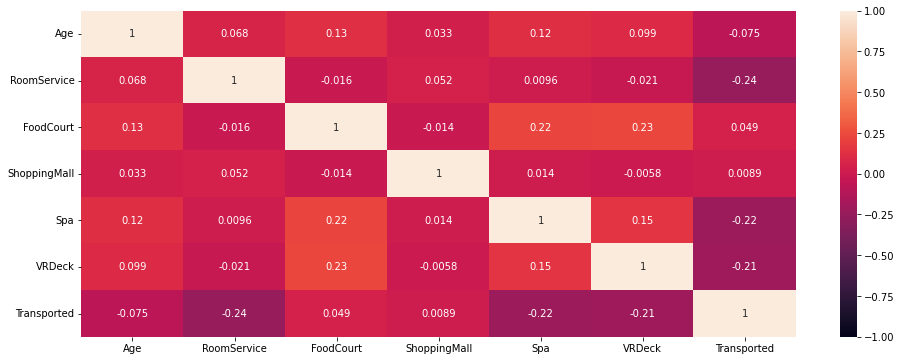

In [168]:
plt.figure(figsize=(16,6))
corr_m=train_df.corr()
sns.heatmap(corr_m,vmin=-1,vmax=1,annot=True)
#train_df.describe()

#####It seems that all of numeric varaibles are not strongly correlated with dependent variable. Keeping them in anaysis will not impact anything.

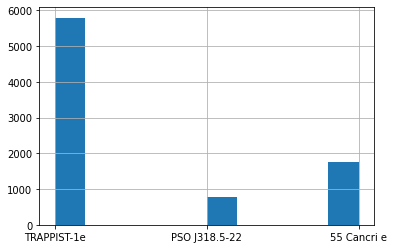

In [169]:
# Lets find out how many were supposed to be transported to different planet
train_df['Destination'].hist()

In [170]:
train_df['CryoSleep'].value_counts()
#train_df['Destination'].hist()


False    5345
True     2961
Name: CryoSleep, dtype: int64

In [171]:
#Lets find out How many VIP were transported ?

train_df.groupby(['VIP']).Transported.mean().to_frame()

,Transported
VIP,
False,0.504869
True,0.384615


In [172]:
#Lets find out How many who had cryosleep were transported ?

train_df.groupby(['CryoSleep']).Transported.mean().to_frame()
# Cryosleep has strong relation to transported.

,Transported
CryoSleep,
False,0.328344
True,0.816954


In [173]:
#Lets find out How many homeplanet related were transported ?

train_df.groupby(['HomePlanet']).Transported.mean().to_frame()

,Transported
HomePlanet,
Earth,0.424989
Europa,0.656430
Mars,0.520349


In [174]:
# Impute missing values for categorical variables by fit transform from sklearn
le=LabelEncoder()
train_df['VIP']=le.fit_transform(train_df['VIP'])
train_df['CryoSleep']=le.fit_transform(train_df['CryoSleep'])
train_df['ShoppinMall']=le.fit_transform(train_df['ShoppingMall'])
train_df['HomePlanet']=le.fit_transform(train_df['HomePlanet'])
train_df['Cabin']=le.fit_transform(train_df['Cabin'])
train_df['Destination']=le.fit_transform(train_df['Destination'])


In [175]:
# Check missing values
draw_missing_data_table(train_df)

,Total,Percent
ShoppingMall,164,0.019356
Spa,153,0.018057
Age,151,0.017821
VRDeck,151,0.017821
RoomService,149,0.017585
FoodCourt,142,0.016759
PassengerId,0,0.000000
HomePlanet,0,0.000000
CryoSleep,0,0.000000
Cabin,0,0.000000


In [176]:

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8473 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8473 non-null   object 
 1   HomePlanet    8473 non-null   int64  
 2   CryoSleep     8473 non-null   int64  
 3   Cabin         8473 non-null   int64  
 4   Destination   8473 non-null   int64  
 5   Age           8322 non-null   float64
 6   VIP           8473 non-null   int64  
 7   RoomService   8324 non-null   float64
 8   FoodCourt     8331 non-null   float64
 9   ShoppingMall  8309 non-null   float64
 10  Spa           8320 non-null   float64
 11  VRDeck        8322 non-null   float64
 12  Transported   8473 non-null   bool   
 13  ShoppinMall   8473 non-null   int64  
dtypes: bool(1), float64(6), int64(6), object(1)
memory usage: 935.0+ KB


In [177]:
# Impute missing values for numerical variables.
#train_df['Age']=train_df['Age'].fillna(train_df['Age'].mean(),inplace=True)
# Check missing values
draw_missing_data_table(train_df)

,Total,Percent
ShoppingMall,164,0.019356
Spa,153,0.018057
Age,151,0.017821
VRDeck,151,0.017821
RoomService,149,0.017585
FoodCourt,142,0.016759
PassengerId,0,0.000000
HomePlanet,0,0.000000
CryoSleep,0,0.000000
Cabin,0,0.000000


In [336]:
#normalize the data
#train_df['Transported'].value_counts(normalize=True)
#train_df['Transported'].astype('uint8')
train_df['Transported'] = list(map(int, train_df['Transported']))
train_df['CryoSleep'] = list(map(float, train_df['CryoSleep']))
train_df['VIP'] = list(map(float, train_df['VIP']))


In [337]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [338]:
# draw a bar chart
def bar_chart_stacked(dataset,feature,stacked=True):
  transported=dataset[dataset['Transported']==True][feature].value_counts
  dead=dataset[dataset['Transported']==False][feature].value_counts()
  df_transported_dead=pd.DataFrame([transported,dead])
  df_transported_dead.index=['Passengers Transnported','Passengers Dead']
  ax=df_transported_dead.plot(kind='bar',stacked=stacked,figsize=(5,5))


In [339]:
# We dont need passengerId for prediction purpose so we should drop it
train_df.drop('PassengerId',axis=1,inplace=True)
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [340]:
#Define categorical variables
#df['Cabin']=pd.Categorical(df['Cabin'])
train_df['Destination']=pd.Categorical(df['Destination'])
train_df['HomePlanet']=pd.Categorical(df['HomePlanet'])
#df['CryoSleep']=pd.Categorical(df['CryoSleep'])
#df['VIP']=pd.Categorical(df['VIP'])
train_df.drop('Name',axis=1,inplace=True)
train_df.drop('Cabin',axis=1,inplace=True)
train_df.drop('ShoppingMall',axis=1,inplace=True)
train_df.drop('VRDeck',axis=1,inplace=True)
train_df.drop('FoodCourt',axis=1,inplace=True)
train_df.drop('Spa',axis=1,inplace=True)
train_df.drop('RoomService',axis=1,inplace=True)
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,1
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,0
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,1


In [341]:
#Drop name ,cabin
df.drop('Name',axis=1,inplace=True)
df.drop('Cabin',axis=1,inplace=True)
df.drop('ShoppingMall',axis=1,inplace=True)
df.drop('VRDeck',axis=1,inplace=True)
df.drop('FoodCourt',axis=1,inplace=True)
df.drop('Spa',axis=1,inplace=True)
df.drop('RoomService',axis=1,inplace=True)
df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,False
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,True
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,False
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,False
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,True


In [342]:
#df['Age'] = df['Age'].fillna(df['Age'].mean()[0])

ma=train_df['Age'].mean()
#modhp=train_df['HomePlanet'].mode()
train_df['Age'].fillna(ma, inplace=True)
#train_df['HomePlanet'].fillna(modhp, inplace=True)
#train_df['CryoSleep'].fillna(train_df['CryoSleep'].mode(), inplace=True)
#SimpleImputer(strategy="most_frequent").fit_transform(train_df[['VIP']])
train_df.CryoSleep = train_df.CryoSleep.dropna()
train_df['VIP'].fillna(train_df['VIP'].mode(), inplace=True)
train_df['Age'].max()

79.0

In [343]:
draw_missing_data_table(train_df)

,Total,Percent
CryoSleep,217,0.024963
VIP,203,0.023352
HomePlanet,201,0.023122
Destination,182,0.020936
Age,0,0.000000
Transported,0,0.000000


In [344]:
# Drop missing values from dataset
train_df.dropna(axis=0,inplace=True)

In [345]:
#Transform categorical variables to dummy variabes
train_df=pd.get_dummies(train_df,drop_first=True)
train_df.head()

,CryoSleep,Age,VIP,Transported,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.0,39.0,0.0,0,1,0,0,1
1,0.0,24.0,0.0,1,0,0,0,1
2,0.0,58.0,1.0,0,1,0,0,1
3,0.0,33.0,0.0,0,1,0,0,1
4,0.0,16.0,0.0,1,0,0,0,1


In [346]:
# Create test train dataset
x=train_df[train_df.loc[:,train_df.columns!='Transported'].columns]
y=train_df['Transported']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)

In [347]:
#Debug
print('Inputs:\n',x_train.head())
print('Outputs:\n',y_train.head())

Inputs:
       CryoSleep   Age  VIP  HomePlanet_Europa  HomePlanet_Mars  \
1527        0.0  25.0  0.0                  0                0   
3448        1.0  56.0  0.0                  1                0   
4314        1.0  25.0  0.0                  1                0   
8495        0.0  27.0  0.0                  0                0   
3398        0.0  15.0  0.0                  0                0   

      Destination_PSO J318.5-22  Destination_TRAPPIST-1e  
1527                          1                        0  
3448                          0                        1  
4314                          0                        1  
8495                          1                        0  
3398                          0                        1  
Outputs:
 1527    0
3448    1
4314    1
8495    0
3398    0
Name: Transported, dtype: int64


In [348]:
draw_missing_data_table(x_train)

,Total,Percent
CryoSleep,0,0.0
Age,0,0.0
VIP,0,0.0
HomePlanet_Europa,0,0.0
HomePlanet_Mars,0,0.0
Destination_PSO J318.5-22,0,0.0
Destination_TRAPPIST-1e,0,0.0


In [293]:
df.dtypes

PassengerId     object
HomePlanet      object
CryoSleep       object
Destination     object
Age            float64
VIP             object
Transported       bool
dtype: object

In [351]:
#Fit logistic regression
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
#Fit random forest
#rf=RandomForestClassifier()
#rf.fit(x_train,y_train)

LogisticRegression()

In [352]:
#model performance
scores=cross_val_score(logreg,x_train,y_train,cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.715 +/- 0.019


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

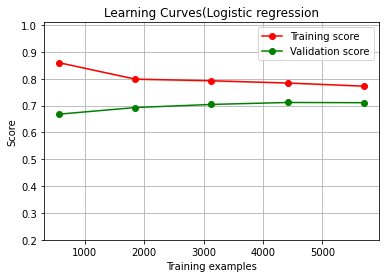

In [353]:
#Accessing model performance
title='Learning Curves(Logistic regression'
cv=10
plot_learning_curve(rf,title, x_train,y_train,ylim=(0.2,1.01),cv=cv,n_jobs=1)

In [354]:
# Predict the data
test=pd.read_csv("test.csv")
test.head()
test1=test[['PassengerId']]
test1.head()

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01


In [355]:
#Drop name ,cabin
test.drop('Name',axis=1,inplace=True)
test.drop('Cabin',axis=1,inplace=True)
test.drop('ShoppingMall',axis=1,inplace=True)
test.drop('VRDeck',axis=1,inplace=True)
test.drop('FoodCourt',axis=1,inplace=True)
test.drop('Spa',axis=1,inplace=True)
test.drop('RoomService',axis=1,inplace=True)
test_x=test
test.head()


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False
2,0019_01,Europa,True,55 Cancri e,31.0,False
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False


In [356]:
ma=df['Age'].mean()
ma
test_x['Age'].fillna(ma, inplace=True)



In [357]:
draw_missing_data_table(test_x)

,Total,Percent
CryoSleep,93,0.021744
VIP,93,0.021744
Destination,92,0.021510
HomePlanet,87,0.020341
PassengerId,0,0.000000
Age,0,0.000000


In [358]:
test_x.drop('PassengerId',axis=1,inplace=True)
test_x.dtypes

HomePlanet      object
CryoSleep       object
Destination     object
Age            float64
VIP             object
dtype: object

In [359]:
#Define categorical variables

test_x['Destination']=pd.Categorical(test_x['Destination'])
test_x['HomePlanet']=pd.Categorical(test_x['HomePlanet'])
test_x['CryoSleep']=pd.Categorical(test_x['CryoSleep'])
test_x['VIP']=pd.Categorical(test_x['VIP'])

In [360]:
#Transform categorical variables to dummy variabes
test_x=pd.get_dummies(test_x,drop_first=True)
test_x.head()

,Age,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True
0,27.0,0,0,1,0,1,0
1,19.0,0,0,0,0,1,0
2,31.0,1,0,1,0,0,0
3,38.0,1,0,0,0,1,0
4,20.0,0,0,0,0,1,0


In [361]:
prd=logreg.predict(test_x)
prd

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- CryoSleep_True
- VIP_True
Feature names seen at fit time, yet now missing:
- CryoSleep
- VIP

  warnings.warn(message, FutureWarning)


array([1, 1, 1, ..., 1, 1, 1])

In [307]:
#op=pd.concat(test[["PassengerId"]],prd)
test1['Transported']=prd
test1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PassengerId,Transported
0,0013_01,1
1,0018_01,1
2,0019_01,1
3,0021_01,1
4,0023_01,1


In [317]:
test1.to_csv("Submission.csv", index=False)

Use neural network to predict binary variable. We will use tensorflow and keras to model and predict values


In [309]:
#Use NN to predict transported column
import tensorflow as tf
# Set random seed
tf.random.set_seed(42)

# Create a model
model_1=tf.keras.Sequential([
                             tf.keras.layers.Dense(100,activation=tf.keras.activations.relu),
                             tf.keras.layers.Dense(100,activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

#Compile the model
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.01),
                metrics=['accuracy'])

#fit the model
history = model_1.fit(x_train,y_train,epochs=30,validation_data=(x_test,y_test))

#model_1.evaulate(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
198/198 [==============================] - 2s 5ms/step - loss: 0.6420 - accuracy: 0.6923 - val_loss: 0.5376 - val_accuracy: 0.7315
Epoch 2/30
198/198 [==============================] - 1s 3ms/step - loss: 0.5499 - accuracy: 0.7240 - val_loss: 0.5366 - val_accuracy: 0.7309
Epoch 3/30
198/198 [==============================] - 1s 3ms/step - loss: 0.5404 - accuracy: 0.7305 - val_loss: 0.5396 - val_accuracy: 0.7328
Epoch 4/30
198/198 [==============================] - 1s 3ms/step - loss: 0.5372 - accuracy: 0.7288 - val_loss: 0.5249 - val_accuracy: 0.7473
Epoch 5/30
198/198 [==============================] - 1s 3ms/step - loss: 0.5308 - accuracy: 0.7313 - val_loss: 0.5481 - val_accuracy: 0.7315
Epoch 6/30
198/198 [==============================] - 1s 3ms/step - loss: 0.5296 - accuracy: 0.7348 - val_loss: 0.5269 - val_accuracy: 0.7467
Epoch 7/30
198/198 [==============================] - 1s 3ms/step - loss: 0.5348 - accuracy: 0.7302 - val_loss: 0.5272 - val_accuracy: 0.7479
Epoch 

In [310]:
# Evaluate model on test set
loss,accuracy=model_1.evaluate(x_test,y_test)

50/50 [==============================] - 0s 2ms/step - loss: 0.5209 - accuracy: 0.7486


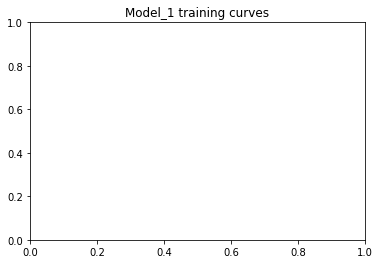

In [311]:
# plot the loss curves
pd.DataFrame(history.history).plot
plt.title('Model_1 training curves')
plt.show()

In [312]:
prd1=model_1.predict(test_x)
prd1

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [316]:
test1.head()


,PassengerId,Transported
0,0013_01,1
1,0018_01,1
2,0019_01,1
3,0021_01,1
4,0023_01,1


In [315]:
#normalize the data
test2=test1[['PassengerId']]
test2['Transported']=prd1
test2['Transported'].value_counts(normalize=True)
test2.head()

,PassengerId,Transported
0,0013_01,1.0
1,0018_01,1.0
2,0019_01,1.0
3,0021_01,1.0
4,0023_01,1.0
